In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import enum
import os

import sys
# sys.path.append( '/content/drive/My Drive/thesis-workspace' ) # drive version
sys.path.append( '../src/' ) # local version

from ml.preprocessing import *
from ml.constants import *

# Loading and generating datasets

In [2]:
# path = [ '.', 'drive', 'My Drive', 'thesis-workspace', 'datasets' ]
path = [ '..', 'datasets' ]

df = pd.read_csv( os.path.join( *path, 'ds-residential-1sec.csv' ) , index_col = 'date', parse_dates = [ 'date' ] )

In [3]:
class DF( enum.Enum ):
    _FULL = 1
    _REDUCED_RFE = 2
    _REDUCED_KBEST = 2
    _MIN = 3

dfs = { DF._FULL: None, DF._REDUCED_RFE: None, DF._REDUCED_KBEST: None, DF._MIN: None }

In [4]:
%%time

def rename_col( name ):
    return name[ 0 ] + '_' + name[ 1 ]

# Minimal features dataset

dfs[ DF._MIN ] = resample_df( df, '10s' ).drop( columns = [ 'ven' ] )
dfs[ DF._MIN ].to_csv( '../datasets/ds-residential-selection-.csv' )

# Extended featues dataset

dfs[ DF._FULL ] = resample_df_avg( df, '10s', [ 'mean', 'std', pd.DataFrame.kurt ] )
dfs[ DF._FULL ].columns = [ rename_col( c ) for c in dfs[ DF._FULL ].columns ]
dfs[ DF._FULL ] = ( dfs[ DF._FULL ]
                   .rename( columns = { 'occ_mode': 'occ' } )
                   .drop( columns = [ 'ven_mode' ] ) )
dfs[ DF._FULL ].to_csv( '../datasets/ds-residential-selection-full.csv' )

# We will need the reference after splitting

df_full = dfs[ DF._FULL ]

CPU times: user 1min 2s, sys: 411 ms, total: 1min 2s
Wall time: 1min 2s


# Normalizing and Balancing

In [5]:
from imblearn.over_sampling import ADASYN
from collections import Counter

# Number of neighbors to use for balancing each dataset

neighbors = { 
    DF._FULL: 1,
    DF._REDUCED_RFE: 1,
    DF._REDUCED_KBEST: 1,
    DF._MIN: 1
}

for k, d in dfs.items() :  
    if( k != DF._REDUCED_RFE and k != DF._REDUCED_KBEST ): 
        temp = list( split_data( d, test_size = 0.20 ) )
        temp[ X_TRAIN ], temp[ X_TEST ] = standardize( temp[ X_TRAIN ], temp[ X_TEST ] )

        print( 'Before balancing:', k, Counter( temp[ Y_TRAIN ] ) )
        temp[ X_TRAIN ], temp[ Y_TRAIN ] = balance_df( 
            temp[ X_TRAIN ], 
            temp[ Y_TRAIN ], 
            neighbors[ k ] )
        print( 'After balancing:', k, Counter( temp[ Y_TRAIN ] ) )
        print()

        dfs[ k ] = temp

Before balancing: DF._FULL Counter({'L': 16301, 'E': 4128, 'M': 2832, 'H': 531})
After balancing: DF._FULL Counter({'E': 16572, 'M': 16402, 'H': 16391, 'L': 16301})

Before balancing: DF._MIN Counter({'L': 16325, 'E': 4098, 'M': 2830, 'H': 547})
After balancing: DF._MIN Counter({'E': 16353, 'M': 16330, 'H': 16329, 'L': 16325})



# Features Selection

In [6]:
from ml.feature_selection import *

## Recursive Feature Elimination 

In [7]:
x_train, x_test, y_train, y_test = dfs[ DF._FULL ]

selected_rfe = select_k_rfe( x_train, y_train, df_full.columns[ : -1 ], 5 )
selected_rfe

,rank,selected
pre_mean,1,1
hum_mean,1,1
hum_std,1,1
tem_mean,1,1
tem_std,1,1
pre_kurt,2,0
pre_std,3,0
tem_kurt,4,0
hum_kurt,5,0


In [8]:
dfs[ DF._REDUCED_RFE ] = df_full.drop( columns = selected_rfe.index[ 5: ] )
dfs[ DF._REDUCED_RFE ].to_csv( '../datasets/ds-residential-selection-rfe.csv' )

## 3.2 Selecting K-best

In [9]:
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions( precision = 2 )

selected_kbest = select_k_best( x_train, y_train, df_full.columns[ : -1 ], 'all' )
selected_kbest

,score,p-value
tem_mean,"11,858.49",0.00
pre_mean,"8,259.23",0.00
hum_mean,"4,795.50",0.00
hum_std,"1,132.49",0.00
pre_std,175.53,0.00
hum_kurt,162.73,0.00
pre_kurt,114.30,0.00
tem_std,31.00,0.00
tem_kurt,10.60,0.00


In [10]:
dfs[ DF._REDUCED_KBEST ] = df_full.drop( columns = selected_kbest.index[ 5: ] )
dfs[ DF._REDUCED_RFE ].to_csv( '../datasets/ds-residential-selection-kbest.csv' )

## 3.3 Feature Correlation

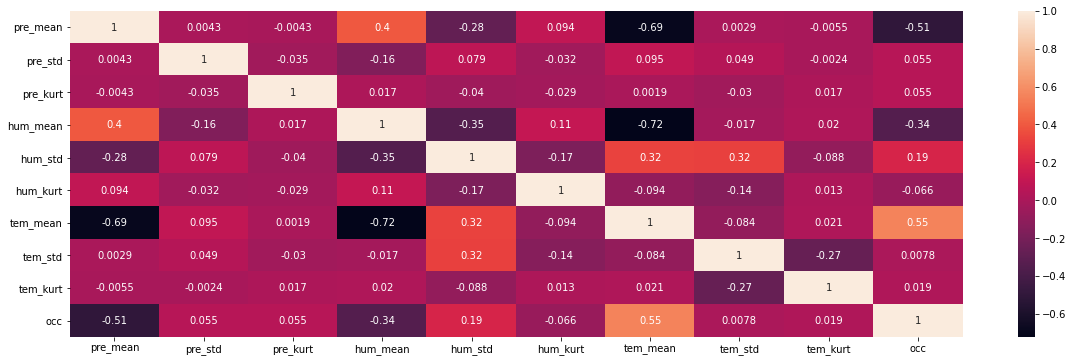

In [11]:
temp = np.concatenate( ( x_train, y_train.replace( { 'E': 0, 'L':1, 'M':2, 'H':3 } ).values.reshape( len( y_train ), 1 ) ), axis = 1 )
temp = pd.DataFrame( data = temp, columns = df_full.columns )

plt.subplots( 1, 1, figsize = ( 20, 6 ) )
sns.heatmap( temp.corr(), annot = True )

Pressure and altitude presents and strong correlation, suggesting we should remove one of them. 